In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git clone https://github.com/fastai/course-v3
%cd /content/course-v3/nbs/dl2
from exp.nb_08 import *

Cloning into 'course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.10 MiB | 13.34 MiB/s, done.
Resolving deltas: 100% (3251/3251), done.
/content/course-v3/nbs/dl2


In [ ]:
torch.optim

<module 'torch.optim' from '/usr/local/lib/python3.7/dist-packages/torch/optim/__init__.py'>

## Load dataset and vanila model

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=2)

In [5]:
nfs = [32, 64, 128, 256]

In [6]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [7]:
learn, run= get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

train: [1.8139950100327384, tensor(0.3672, device='cuda:0')]
valid: [1.6473867933917197, tensor(0.4306, device='cuda:0')]


---

## Refining the optimizer

In [8]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)        
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        gps = []
        for pg, hyper in zip(self.param_groups, self.hypers):
            for p in pg:
                if p.grad is not None:
                    gps = gps + [(p, hyper)]
        return gps
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    def step(self):
        for p, hyper in grad_params:
            compose(p, self.steppers, **hyper)

In [9]:
def sgd_step(p, lr, **kwargs):
    print(f"lr: {lr}\nkwargs: {kwargs}")
    # pytorch inplace function of sum. second parameter will be multiplied to first parameter
    p.data.add_(-lr, p.grad.data)
    return p
# steppers is compositional function
opt_func = partial(Optimizer, steppers=[sgd_step])

In [ ]:
Optimizer(learn.model.parameters(), sgd_step).param_groups

[[Parameter containing:
  tensor([[[[ 0.3289,  0.2969,  0.0545],
            [-0.0472,  0.2823,  0.1843],
            [-0.1065,  0.2787, -0.1526]],
  
           [[ 0.2337,  0.3831,  0.0793],
            [-0.1422, -0.1537,  0.1516],
            [ 0.1776,  0.8838,  0.1525]],
  
           [[ 0.4825,  0.0050,  0.2736],
            [-0.0998,  0.2738,  0.1084],
            [-0.0649,  0.1470, -0.0415]]],
  
  
          [[[ 0.3343, -0.1267,  0.1231],
            [ 0.0606,  0.2506,  0.3913],
            [ 0.7008,  0.0214,  0.3130]],
  
           [[-0.1296, -0.2690,  0.2535],
            [-0.2055, -0.2898,  0.3143],
            [ 0.1537, -0.2819, -0.0739]],
  
           [[ 0.1057, -0.3752,  0.2703],
            [-0.0540,  0.2486,  0.1926],
            [ 0.0905,  0.3146, -0.0874]]],
  
  
          [[[ 0.1146, -0.4689,  0.3813],
            [ 0.0655, -0.3051, -0.3552],
            [ 0.0393, -0.1617,  0.0360]],
  
           [[ 0.4338, -0.2380,  0.1627],
            [-0.0490,  0.1799, -0.0997

qq: Can I get a pre-defined keyword parameter as an **kwargs?
this is because, as compose function only gets function and value, but sgd_step (which might be one of the compositional functions) requires lr parameter

In [ ]:
dir(torch.optim)

- Q3

In [ ]:
print(inspect.getsource(Recorder))

In [ ]:
torch_opt_func = torch.optim.SGD(learn.model.parameters(), lr=0.3)

In [ ]:
torch_opt_func

In [ ]:
torch_opt_func.param_groups

In [ ]:
learn.model

In [ ]:
torch_opt_func.param_groups[0]['params'].__len__()

23

In [10]:
# original one (i.e., dependency on pytorch)
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [79]:
# adjusted one
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr  (self, pgid=-1): plt.plot(self.lrs)
    def plot_loss(self, skip_last=0): plt.plot(self.losses)

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [68]:
# original one
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs

    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)

    def begin_batch(self):
        if self.in_train: self.set_param()

class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname, listify(sched_funcs)

    def begin_batch(self):
        if not self.in_train: return
        fs = self.sched_funcs
        "I don't know why we should multiply(i.e., copy) the number of pg here when (only) the length is one"
        if len(fs) == 1:
            # print(f"before multiplying: {fs}")
            fs = fs * len(self.opt.param_groups)
            # print(f"after multiplying: {fs}")
        pos = self.n_epochs / self.epochs
        for f, h in zip(fs, self.opt.hypers):
            h[self.pname] = f(pos)

In [61]:
learn.opt.param_groups.__len__()

1

In [13]:
# original one

class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr

    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

# adjusted one

class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
    
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        # New
        for pg in self.opt.hyper: pg['lr'] = lr
    
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

## Weight decay - AdamW

In [14]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1-lr*wd)
    return p
weight_decay._defaults = dict({'wd':0.})

In [15]:
def l2_reg(p, lr, wd, **kwargs):
    p.data.grad.add_(lr, wd)
    return p
l2_reg._defaults = dict({'wd':0.})

In [30]:
def sgd_step(p, lr, **kwargs):
    # pytorch inplace function of sum. second parameter will be multiplied to first parameter
    p.data.add_(-lr, p.grad.data)
    return p

In [34]:
sum([0.4, 0.3, 0.2, 0.1])

0.9999999999999999

- To see first layer output

```
learn.model[0]
param_groups[0].shape
xb, yb = next(iter(data.train_dl))
xb.shape
learn.model[0].forward(xb).shape
```

In [55]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)        
        self.param_groups = list(params)
        maybe_update(self.steppers, defaults, get_defaults)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        gps = []
        for pg, hyper in zip(self.param_groups, self.hypers):
            for p in pg:
                if p.grad is not None:
                    gps = gps + [(p, hyper)]
        return gps
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [18]:
def maybe_update(os, dest, f):
    '''
    os: optimizers
    '''
    for o in os:
        for k, v in f(o).items():
            if not k in dest: dest[k] = v
def get_defaults(o): return getattr(o, '_defaults', {})            

In [56]:
sgd_opt = partial(Optimizer, steppers = [weight_decay,sgd_step])

In [40]:
import inspect
inspect.getfullargspec(get_learn_run)

FullArgSpec(args=['nfs', 'data', 'lr', 'layer', 'cbs', 'opt_func'], varargs=None, varkw='kwargs', defaults=(None, None), kwonlyargs=[], kwonlydefaults=None, annotations={})

- I don't know how the length of parameter group gets bigger than 1.

In [43]:
sched = combine_scheds(torch.tensor([.4, .3, .2, .1]), [sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01), sched_cos(0.8, .01)])

In [42]:
cbfs

[functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f2085933e60>),
 exp.nb_06.CudaCallback,
 functools.partial(<class 'exp.nb_06.BatchTransformXCallback'>, functools.partial(<function normalize_chan at 0x7f1f79b5e050>, mean=tensor([0.4700, 0.4800, 0.4500], device='cuda:0'), std=tensor([0.2900, 0.2800, 0.3000], device='cuda:0')))]

In [80]:
learn, run= get_learn_run(nfs, data, 0.4, conv_layer,
                          cbs=cbfs + [partial(ParamScheduler, pname='lr', sched_funcs=sched), Recorder],
                          opt_func = sgd_opt)

In [81]:
run.fit(1, learn)

train: [1.906849200351146, tensor(0.3447, device='cuda:0')]
valid: [1.6567807026273886, tensor(0.4408, device='cuda:0')]


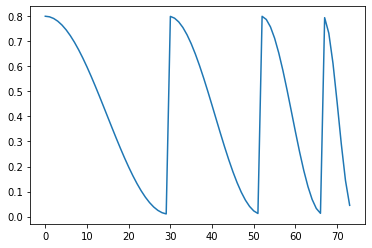

In [82]:
run.recorder.plot_lr()

TypeError: ignored

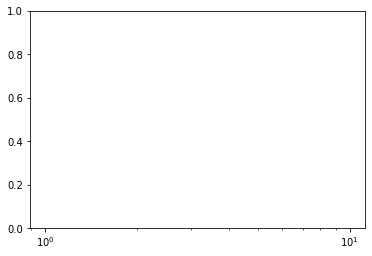

In [83]:
run.recorder.plot() #TODO

In [84]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [85]:
learn.opt.hypers #TODO

[{'lr': 0.04506473956948709, 'wd': 0.0}]

- Let's calculate number of parameters quickly

In [96]:
mps = [len(p.storage()) for p in learn.opt.param_groups[-1]]
f"Total parameters: {sum(mps)},\n parameter list: {mps}"

'Total parameters: 432730,\n parameter list: [432, 16, 16, 4608, 32, 32, 18432, 64, 64, 18432, 32, 32, 18432, 64, 64, 73728, 128, 128, 294912, 256, 256, 2560, 10]'

- Checking stride, storage, shape
```
p1, p2 = learn.opt.param_groups[-1][0], learn.opt.param_groups[-1][-2]
p1.shape, p2.shape
p1.stride(), p2.stride()
```